<a href="https://colab.research.google.com/github/AndreaDAlcantara/DS_Portfolio/blob/main/TwitterSentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Sentiment Analysis with SnScrape, TextBlob and NLTK

In [2]:
!pip install snscrape 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 KB 3.3 MB/s eta 0:00:00


In [3]:
#Importing Libraries
import pandas as pd
import numpy as np
import snscrape.modules.twitter as sntwitter
import datetime
from tqdm.notebook import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

from textblob import TextBlob
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
import json
import itertools
import collections
from collections import Counter


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Sentiment Analysis using Twitter (text search)

Scraping tweets from World Cup 1st and last week with the text "World Cup Qatar".

In [4]:
maxTweets = 500

tweets_list1 = []
tweets_list2 = []

for i,tweet in enumerate(sntwitter.TwitterSearchScraper('World Cup Qatar since:2022-11-19 until:2022-11-27').get_items()):
    if i>maxTweets:
        break
    tweets_list1.append([tweet.date, tweet.id, tweet.rawContent, tweet.user.username])

tweets_wc1 = pd.DataFrame(tweets_list1, columns=['Datetime', 'Tweet Id', 'Text', 'Username'])

for i,tweet in enumerate(sntwitter.TwitterSearchScraper('World Cup Qatar since:2022-12-10 until:2022-12-19').get_items()):
    if i>maxTweets:
        break
    tweets_list2.append([tweet.date, tweet.id, tweet.rawContent, tweet.user.username])

tweets_wc2 = pd.DataFrame(tweets_list2, columns=['Datetime', 'Tweet Id', 'Text', 'Username'])

#tweets_df.head()

Using TextBlob to analyse the sentiment of the words and count them in the scraped tweets.

In [5]:
#Finding sentiment analysis (positive, negative and neutral)
pos1 = 0
neg1 = 0
neu1 = 0
for i in range(len(tweets_wc1)):
    analysis = TextBlob(tweets_wc1.loc[i, "Text"])
    if analysis.sentiment[0]>0:
       pos1 = pos1 +1
    elif analysis.sentiment[0]<0:
       neg1 = neg1 + 1
    else:
       neu1 = neu1 + 1
print("1st week of World Cup")
print("Total Positive = ", pos1)
print("Total Negative = ", neg1)
print("Total Neutral = ", neu1)

pos2 = 0
neg2 = 0
neu2 = 0
for i in range(len(tweets_wc2)):
    analysis = TextBlob(tweets_wc2.loc[i, "Text"])
    if analysis.sentiment[0]>0:
       pos2 = pos2 +1
    elif analysis.sentiment[0]<0:
       neg2 = neg2 + 1
    else:
       neu2 = neu2 + 1
print("Last week of World Cup")
print("Total Positive = ", pos2)
print("Total Negative = ", neg2)
print("Total Neutral = ", neu2)

1st week of World Cup
Total Positive =  181
Total Negative =  70
Total Neutral =  250
Last week of World Cup
Total Positive =  303
Total Negative =  57
Total Neutral =  141


Plotting the analysis comparing both weeks.

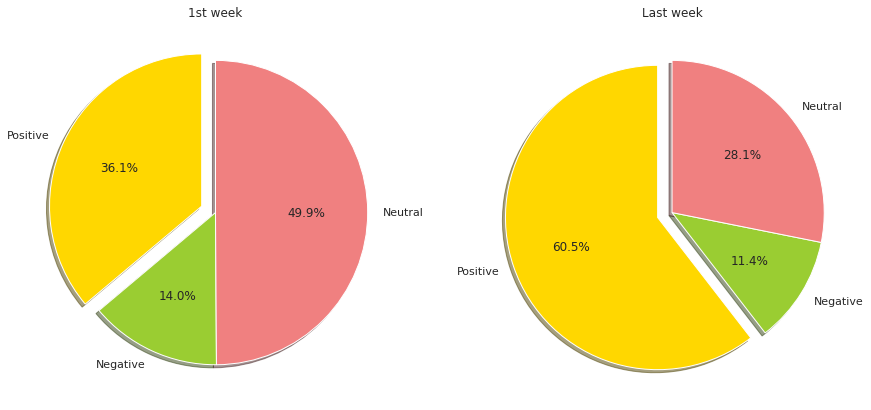

In [33]:
from pandas.compat import platform
#Plotting sentiments
labels = 'Positive', 'Negative', 'Neutral'
sizes1 = [pos1, neg1, neu1]
colors = ['gold', 'yellowgreen', 'lightcoral']
explode = (0.1, 0, 0)  # explode 1st slice

fig1 = plt.figure(figsize = (15,10)) # create a figure with the default size 
ax1 = fig1.add_subplot(1,2,1) 
plt.pie(sizes1, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('1st week');

sizes2 = [pos2, neg2, neu2]
ax2 = fig1.add_subplot(1,2,2) 
plt.pie(sizes2, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Last week');



Cleaning data from tweets in order to only use relevant words.

In [7]:
#Cleaning Data

#Removing @ handle
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt 

tweets_wc1["Text"] = np.vectorize(remove_pattern)(tweets_wc1["Text"], "@[\w]*")
tweets_wc2["Text"] = np.vectorize(remove_pattern)(tweets_wc2["Text"], "@[\w]*")
#tweets_wc1.head()

In [8]:
#Cleaning Tweets
corpus1 = []
corpus2 = []
for i in range(0, 500):
    tweet = re.sub('[^a-zA-Z0-9]', ' ', tweets_wc1["Text"][i])
    tweet = tweet.lower()
    tweet = re.sub('rt', '', tweet)
    tweet = re.sub('http', '', tweet)
    tweet = re.sub('https', '', tweet)
    tweet = re.sub('t.co', '', tweet)
    tweet = re.sub('world', '', tweet)
    tweet = re.sub('cup', '', tweet)
    tweet = re.sub('fifa', '', tweet)
    tweet = tweet.split()
    ps = PorterStemmer()
    tweet = [ps.stem(word) for word in tweet if not word in set(stopwords.words('english'))]
    tweet = ' '.join(tweet)
    corpus1.append(tweet)

for i in range(0, 500):
    tweet = re.sub('[^a-zA-Z0-9]', ' ', tweets_wc2["Text"][i])
    tweet = tweet.lower()
    tweet = re.sub('rt', '', tweet)
    tweet = re.sub('http', '', tweet)
    tweet = re.sub('https', '', tweet)
    tweet = re.sub('t.co', '', tweet)
    tweet = re.sub('world', '', tweet)
    tweet = re.sub('cup', '', tweet)
    tweet = re.sub('fifa', '', tweet)
    tweet = tweet.split()
    ps = PorterStemmer()
    tweet = [ps.stem(word) for word in tweet if not word in set(stopwords.words('english'))]
    tweet = ' '.join(tweet)
    corpus2.append(tweet)

Plotting the word clouds with relevant words comparing both weeks.

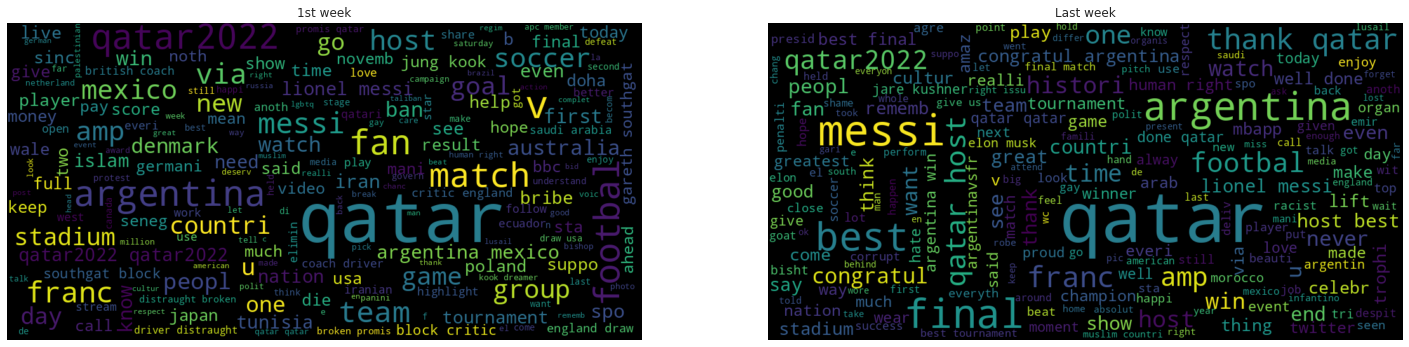

In [36]:
#Word Cloud
all_words1 = ' '.join([text for text in corpus1])
wordcloud1 = WordCloud(width=1000, height=500, random_state=21, max_font_size=110).generate(all_words1)
all_words2 = ' '.join([text for text in corpus2])
wordcloud2 = WordCloud(width=1000, height=500, random_state=21, max_font_size=110).generate(all_words2)

fig1 = plt.figure(figsize = (25,20))
ax1 = fig1.add_subplot(1,2,1)
im1 = plt.imshow(wordcloud1, interpolation="bilinear")
plt.axis('off')
plt.title('1st week');

ax2 = fig1.add_subplot(1,2,2) 
im2 = plt.imshow(wordcloud2, interpolation="bilinear")
plt.axis('off')
plt.title('Last week');




In [37]:
words_in_tweet1 = [tweet.lower().split() for tweet in corpus1]
words_in_tweet2 = [tweet.lower().split() for tweet in corpus2]

In [38]:
from collections import Counter
# List of all words across tweets
all_words_no_urls1 = list(itertools.chain(*words_in_tweet1))

# Create counter
counts_no_urls1 = collections.Counter(all_words_no_urls1)
print("1st week")
counts_no_urls1.most_common(10)

1st week


[('qatar', 539),
 ('2022', 212),
 ('qatar2022', 70),
 ('0', 62),
 ('argentina', 60),
 ('2', 59),
 ('footbal', 53),
 ('vs', 51),
 ('fan', 51),
 ('messi', 48)]

In [39]:
# List of all words across tweets
all_words_no_urls2 = list(itertools.chain(*words_in_tweet2))

# Create counter
counts_no_urls2 = collections.Counter(all_words_no_urls2)
print("Last week")
counts_no_urls2.most_common(10)

Last week


[('qatar', 571),
 ('2022', 139),
 ('best', 124),
 ('messi', 119),
 ('argentina', 113),
 ('final', 111),
 ('host', 88),
 ('ever', 83),
 ('thank', 63),
 ('franc', 42)]

# Sentiment Analysis from a twitter account

Scraping tweets from World Cup 1st and last week within the ESPN account.

In [49]:
maxTweets = 500
tweets_list_fs1 = []
tweets_list_fs2 = []
 
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('from:FoxSoccer since:2022-11-19 until:2022-11-27').get_items()):
    if i>maxTweets:
        break
    tweets_list_fs1.append([tweet.date, tweet.id, tweet.rawContent, tweet.user.username])

tweets_fs1 = pd.DataFrame(tweets_list_fs1, columns=['Datetime', 'Tweet Id', 'Text', 'Username'])

for i,tweet in enumerate(sntwitter.TwitterSearchScraper('from:FoxSoccer since:2022-12-10 until:2022-12-19').get_items()):
    if i>maxTweets:
        break
    tweets_list_fs2.append([tweet.date, tweet.id, tweet.rawContent, tweet.user.username])

tweets_fs2 = pd.DataFrame(tweets_list_fs2, columns=['Datetime', 'Tweet Id', 'Text', 'Username'])

#tweets_fs1
#tweets_fs2

Using TextBlob to analyse the sentiment of the words and count them in the scraped tweets.

In [50]:
#Finding sentiment analysis (positive, negative and neutral)
pos1 = 0
neg1 = 0
neu1 = 0
for i in range(len(tweets_fs1)):
    analysis = TextBlob(tweets_fs1.loc[i, "Text"])
    if analysis.sentiment[0]>0:
       pos1 = pos1 +1
    elif analysis.sentiment[0]<0:
       neg1 = neg1 + 1
    else:
       neu1 = neu1 + 1
print("1st week of World Cup")
print("Total Positive = ", pos1)
print("Total Negative = ", neg1)
print("Total Neutral = ", neu1)

pos2 = 0
neg2 = 0
neu2 = 0
for i in range(len(tweets_fs2)):
    analysis = TextBlob(tweets_fs2.loc[i, "Text"])
    if analysis.sentiment[0]>0:
       pos2 = pos2 +1
    elif analysis.sentiment[0]<0:
       neg2 = neg2 + 1
    else:
       neu2 = neu2 + 1
print("Last week of World Cup")
print("Total Positive = ", pos2)
print("Total Negative = ", neg2)
print("Total Neutral = ", neu2)

1st week of World Cup
Total Positive =  198
Total Negative =  55
Total Neutral =  248
Last week of World Cup
Total Positive =  205
Total Negative =  65
Total Neutral =  231


Plotting the analysis comparing both weeks.

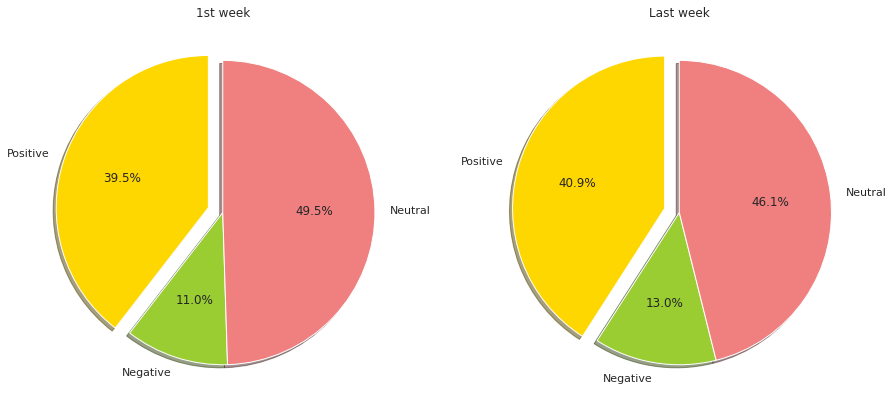

In [51]:
#Plotting sentiments
labels = 'Positive', 'Negative', 'Neutral'
sizes1 = [pos1, neg1, neu1]
colors = ['gold', 'yellowgreen', 'lightcoral']
explode = (0.1, 0, 0)  # explode 1st slice

fig1 = plt.figure(figsize = (15,10)) # create a figure with the default size 
ax1 = fig1.add_subplot(1,2,1) 
plt.pie(sizes1, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('1st week');

sizes2 = [pos2, neg2, neu2]
ax2 = fig1.add_subplot(1,2,2) 
plt.pie(sizes2, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Last week');

Cleaning data from tweets in order to only use relevant words.

In [52]:
# Cleaning Data

tweets_fs1["Text"] = np.vectorize(remove_pattern)(tweets_fs1["Text"], "@[\w]*")
tweets_fs2["Text"] = np.vectorize(remove_pattern)(tweets_fs2["Text"], "@[\w]*")
#tweets_fs1.head()

In [53]:
#Cleaning Tweets
corpus1 = []
corpus2 = []
for i in range(0, 500):
    tweet = re.sub('[^a-zA-Z0-9]', ' ', tweets_fs1["Text"][i])
    tweet = tweet.lower()
    tweet = re.sub('rt', '', tweet)
    tweet = re.sub('http', '', tweet)
    tweet = re.sub('https', '', tweet)
    tweet = re.sub('t.co', '', tweet)
    tweet = re.sub('world', '', tweet)
    tweet = re.sub('cup', '', tweet)
    tweet = re.sub('fifa', '', tweet)
    tweet = tweet.split()
    ps = PorterStemmer()
    tweet = [ps.stem(word) for word in tweet if not word in set(stopwords.words('english'))]
    tweet = ' '.join(tweet)
    corpus1.append(tweet)

for i in range(0, 500):
    tweet = re.sub('[^a-zA-Z0-9]', ' ', tweets_fs2["Text"][i])
    tweet = tweet.lower()
    tweet = re.sub('rt', '', tweet)
    tweet = re.sub('http', '', tweet)
    tweet = re.sub('https', '', tweet)
    tweet = re.sub('t.co', '', tweet)
    tweet = re.sub('world', '', tweet)
    tweet = re.sub('cup', '', tweet)
    tweet = re.sub('fifa', '', tweet)
    tweet = tweet.split()
    ps = PorterStemmer()
    tweet = [ps.stem(word) for word in tweet if not word in set(stopwords.words('english'))]
    tweet = ' '.join(tweet)
    corpus2.append(tweet)

Plotting the word clouds with relevant words comparing both weeks.

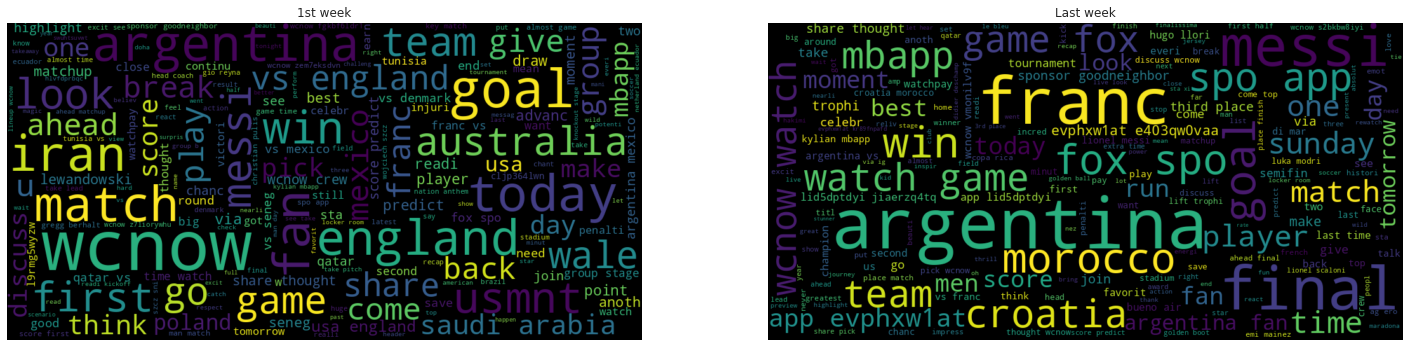

In [54]:
#Word Cloud
all_words1 = ' '.join([text for text in corpus1])
wordcloud1 = WordCloud(width=1000, height=500, random_state=21, max_font_size=110).generate(all_words1)
all_words2 = ' '.join([text for text in corpus2])
wordcloud2 = WordCloud(width=1000, height=500, random_state=21, max_font_size=110).generate(all_words2)

fig1 = plt.figure(figsize = (25,20))
ax1 = fig1.add_subplot(1,2,1)
im1 = plt.imshow(wordcloud1, interpolation="bilinear")
plt.axis('off')
plt.title('1st week');

ax2 = fig1.add_subplot(1,2,2) 
im2 = plt.imshow(wordcloud2, interpolation="bilinear")
plt.axis('off')
plt.title('Last week');

In [55]:
words_in_tweet1 = [tweet.lower().split() for tweet in corpus1]
words_in_tweet2 = [tweet.lower().split() for tweet in corpus2]

In [56]:
from collections import Counter
# List of all words across tweets
all_words_no_urls1 = list(itertools.chain(*words_in_tweet1))

# Create counter
counts_no_urls1 = collections.Counter(all_words_no_urls1)

print("1st week")
counts_no_urls1.most_common(10)


1st week


[('wcnow', 127),
 ('vs', 77),
 ('england', 75),
 ('match', 53),
 ('argentina', 51),
 ('goal', 46),
 ('today', 42),
 ('fan', 40),
 ('iran', 40),
 ('mexico', 38)]

In [57]:
# List of all words across tweets
all_words_no_urls2 = list(itertools.chain(*words_in_tweet2))

# Create counter
counts_no_urls2 = collections.Counter(all_words_no_urls2)

print("Last week")
counts_no_urls2.most_common(10)


Last week


[('argentina', 147),
 ('franc', 110),
 ('final', 93),
 ('messi', 87),
 ('2022', 79),
 ('wcnow', 66),
 ('game', 57),
 ('watch', 54),
 ('morocco', 46),
 ('goal', 43)]